In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

import pandas as pd
import numpy as np
import random
import csv
import os
from sklearn.metrics import f1_score, precision_score, recall_score, median_absolute_error, mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers.models.bert import modeling_bert

In [211]:
# Function to map hexbin plot colors
def my_reduce(x):
    npsum = np.sum(x)
    return np.log(npsum)

                
# Function to test model            
def test_model(model,input_function, test_loader, criterion, verbose = False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval() # enable evaluation mode
    valid_loss = 0
    valid_preds, valid_labels = [], []
    
    if verbose == 2:
        status = test_loader
    else:
        status = tqdm_notebook(test_loader, 0)
        
    for i, data in enumerate(status):
        # get the inputs; data is a tuple of lists: [inputs, labels]
        inputs, labels = data
        input_tensors = input_function(inputs)
        labels =  labels.to(device)
        
        outputs = model(*input_tensors)
        loss = criterion(outputs[0].to(torch.float32),labels.to(torch.float32))
        valid_preds.append(outputs[0].cpu().detach().item())
        valid_labels.append(labels.cpu().detach().item())
        valid_loss += loss.item()

    valid_mse = mean_squared_error(valid_labels, valid_preds)
    valid_maerr = mean_absolute_error(valid_labels, valid_preds)
    
    if verbose !=2:
        print("\nTest Results:\n\t\tLoss: {:.6f}".format(valid_loss / len(test_loader)))
        print("\t\tTotal Mean Squared Error: {:.4f}".format(valid_mse))
        print("\t\tTotal Mean Absolute Error: {:.4f}\n".format(valid_maerr))

        # Plots

        # Prepare Hexbin plot
        temp_df = pd.DataFrame(zip(valid_preds,valid_labels), columns = ['Predicted values', 'Hops'])
        temp_df['Hops'] = 1/temp_df['Hops']
        temp_df['C'] = 1

        if verbose:
            fig, axes = plt.subplots(4,1, figsize = (10,20))
        else:
            fig, axes = plt.subplots(2,1, figsize = (10,10))

        temp_df.plot.hexbin(ax = axes[0], x ='Hops', y='Predicted values',C = 'C', reduce_C_function=my_reduce,colormap="viridis")
        axes[0].set_title("Hexbin Plot")
    
    # Calculate metrics per Hop
    mse = []
    mae = []
    high1_p=high_close_p=high_mid_p=high_far_p=high1_n=high_close_n=high_mid_n=high_far_n=0
    for i in range(1,31):
        target = 1/i
        preds = []
        trues = []
        for predicted, true in zip(valid_preds, valid_labels):
            if true == target:
                preds.append(predicted)
                trues.append(true)
                if predicted > 0.45:
                    if i==1:
                        high1_p +=1
                    elif i<4:
                        high_close_p +=1
                    elif i<11:
                        high_mid_p +=1
                    else:
                        high_far_p +=1
                else:
                    if i==1:
                        high1_n +=1
                    elif i<4:
                        high_close_n +=1
                    elif i<11:
                        high_mid_n +=1
                    else:
                        high_far_n +=1
        if len(trues)==0:
            continue
        mae.append(mean_absolute_error(trues, preds))
        mse.append(mean_squared_error(trues, preds))
        if i<4 and verbose != 2:
            print(" Hop '"+str(i)+"'\tMAE: {:.4f}, MSE: {:.4f}".format(mae[i-1],mse[i-1])) 
        if i==1:
            hist_preds = preds
    if high1_n == 0: high1_n=1
    if high_close_n == 0: high_close_n=1
    if high_mid_n == 0: high_mid_n=1
    if high_far_n == 0: high_far_n=1
    p1 = high1_p*100/(high1_p+high1_n)
    p2 = high_close_p*100/(high_close_p+high_close_n)
    p3 = high_mid_p*100/(high_mid_p+high_mid_n)
    p4 = high_far_p*100/(high_far_p+high_far_n)
    tp = high1_p
    tn = high_mid_n + high_far_n
    fp = high_mid_p + high_far_p
    fn = high1_n
    if fp == 0: fp = 1
    pseudo_precision = tp/(tp + fp)
    pseudo_recall = tp/(tp + fn)
    pseudo_accuracy = (tp + tn) / (tp + fn + tn +fp)
    if pseudo_recall == 0 and pseudo_accuracy == 0 :
        pseudo_f1 = 0
        f1g = 0
    else:
        pseudo_f1 = 2 * pseudo_precision * pseudo_recall / (pseudo_precision + pseudo_recall)
        proportion = (high1_n + high1_p)/(high_mid_p + high_mid_n + high_far_p + high_far_n)
    #     precisionGain = (pseudo_precision - proportion)/(pseudo_precision * (1 - proportion))
    #     recallGain = (pseudo_recall - proportion)/(pseudo_recall * (1 - proportion))
        f1g = (pseudo_f1 - proportion)/(pseudo_f1 * (1 - proportion))
    
    if verbose !=2:
#         print("\nPercentage of high prediction (>0.5): ")
        print("\nPercentage of prediction > 0.45: ")
        print(" Hop  1: \t{:.4f}%".format(p1))
        print(" Hops 2-3: \t{:.4f}%".format(p2))
        print(" Hops 4-10: \t{:.4f}%".format(p3))
        print(" Hops 11+: \t{:.4f}%".format(p4))
        
        print("\nPseudo binary metrics (ignoring Hops 2 & 3): ")
        print("Precision: \t{:.4f}%".format(pseudo_precision*100))
        print("Recall: \t{:.4f}%".format(pseudo_recall*100))
        print("Accuracy: \t{:.4f}%".format(pseudo_accuracy*100))
        print("f1: \t\t{:.4f}%".format(pseudo_f1*100))
        print("f1 Gain: \t{:.4f}%".format(f1g*100))
    
        if high1_n>1:
            sns.histplot(hist_preds,ax = axes[1], bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3], color = 'lime')
#             sns.histplot(hist_preds,ax = axes[1], color = 'lime')
        axes[1].set_title("Prediction distribution for Hop '1'")
        axes[1].grid(axis = 'y', alpha = 0.5)

        if verbose:
            axes[2].bar(range(1,len(mse)+1), mse, color = 'lightcoral')
            axes[2].set_title("Mean Squared Error per Hop")
            axes[2].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mse):
                axes[2].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)

            axes[3].bar(range(1,len(mae)+1), mae, color = 'royalblue')
            axes[3].set_title("Mean Absolute Error per Hop")
            axes[3].grid(axis = 'y', alpha = 0.5)
            for i, v in enumerate(mae):
                axes[3].text(i+0.9 , 0.01, str(round(v,4)), color='black',fontsize = 8, fontweight='bold', rotation = 90)
        plt.show()
   
#     return {'pseudo_precision': pseudo_precision, 'pseudo_recall':pseudo_recall, 'pseudo_accuracy': pseudo_accuracy, 'pseudo_f1': pseudo_f1 ,'mse_list': mse, 'mae_list': mae, "Hop1 High": p1,'Hop2-3 High%': p2, 'Hop4-10 High%': p3, 'Hop11+ High%': p4, 'loss':(valid_loss / len(test_loader))}
    return valid_preds, valid_labels


In [17]:
def inverse_transform(Hops):
    return (1/Hops)


def joining(text1, text2):
    text = text1
    text += f" [SEP] "+text2
    return text


def Load_Datasets(Dataset_version,y_transform = inverse_transform, Max_Hops_Samples_relativeToHop1 = 1.1, ValidationPercentageSplit = 0.1, SubTrainPercentage = 0.1, verbose = True):
    # Load whole Train dataset
    data_train = pd.read_csv('../KEGG Undirected Graph Dataset/Hops Dataset '+Dataset_version+' - A.csv', header=0)
    data_train = data_train[data_train["Hops"]>0]

    # Load whole Test dataset
    data_test = pd.read_csv('../KEGG Undirected Graph Dataset/Hops Dataset '+Dataset_version+' - B.csv', header=0)
    data_test = data_test[data_test["Hops"]>0]

    # Balanced (subsampled) datasets
    data_train_balanced = data_train.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train[data_train['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    data_test_balanced = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test[data_test['Hops']==1])*Max_Hops_Samples_relativeToHop1))))

    # Validation Dataset. Initialize from data
    data_valid = data_test.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_test_balanced[data_test_balanced['Hops']==1])*ValidationPercentageSplit))))
    # Remove any entry given to the validation set from the balanced test set
    data_test = data_test[~data_test.isin(data_valid)].dropna()

    # Subsampled train set to monitor overfitting behaviour
    data_sub_train = data_train_balanced.groupby('Hops', group_keys=False).apply(
        lambda x: x.sample(min(len(x), round(len(data_train_balanced[data_train_balanced['Hops']==1])*SubTrainPercentage))))

    if verbose: 
        fig, axes = plt.subplots(1,2, figsize = (25,10), sharey = True, sharex = True)
        all_sns_bins = list(range(1,25))
        print("Raw Train data: "+str(data_train.shape[0])+" samples")
        sns.histplot(data_train["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Raw Train data: "+str(data_train.shape[0])+" samples")
        print("Raw Test data: "+str(data_test.shape[0])+" samples")
        sns.histplot(data_test["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Raw Test data: "+str(data_test.shape[0])+" samples")
        plt.show()

        fig, axes = plt.subplots(1,3, figsize = (25,10), sharey = True, sharex = True)
        print("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        sns.histplot(data_train_balanced["Hops"],ax = axes[0], bins = all_sns_bins)
        axes[0].set_title("Balanced Train data: "+str(data_train_balanced.shape[0])+" samples")
        print("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_valid["Hops"],ax = axes[1], bins = all_sns_bins)
        axes[1].set_title("Validation data: "+str(data_valid.shape[0])+" samples")
        sns.histplot(data_test_balanced["Hops"],ax = axes[2], bins = all_sns_bins)
        axes[2].set_title("Balanced Test data - no overlap: "+str(data_test_balanced.shape[0])+" samples")
        plt.show()

    data_train_balanced["Hops"] = y_transform(data_train_balanced["Hops"])
    if verbose: print(data_train_balanced)
    y_train = pd.to_numeric(data_train_balanced.Hops)#.astype(int)
    x_train = np.vectorize(joining)(data_train_balanced.Head.astype(str),data_train_balanced.Tail.astype(str))
    if verbose: print(x_train[0])
        
    data_valid["Hops"] = y_transform(data_valid["Hops"])
    y_valid = pd.to_numeric(data_valid.Hops)#.astype(int)
    x_valid = np.vectorize(joining)(data_valid.Head.astype(str),data_valid.Tail.astype(str))

    data_sub_train["Hops"] = y_transform(data_sub_train["Hops"])
    y_sub_train = pd.to_numeric(data_sub_train.Hops)#.astype(int)
    x_sub_train = np.vectorize(joining)(data_sub_train.Head.astype(str),data_sub_train.Tail.astype(str))

    data_test_balanced["Hops"] = y_transform(data_test_balanced["Hops"])
    y_test_balanced = pd.to_numeric(data_test_balanced.Hops)#.astype(int)
    x_test_balanced = np.vectorize(joining)(data_test_balanced.Head.astype(str),data_test_balanced.Tail.astype(str))
    
    return x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced

Raw Train data: 2027091 samples
Raw Test data: 3902132 samples


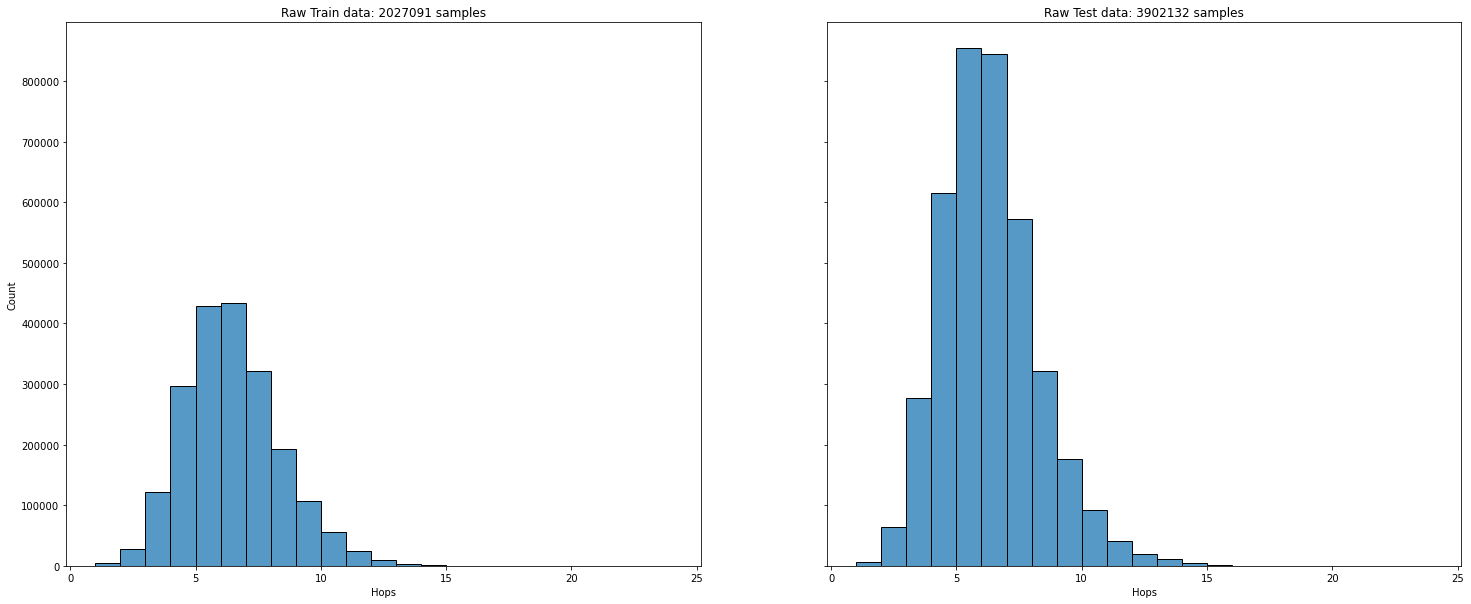

Balanced Train data: 58974 samples
Validation data: 5278 samples


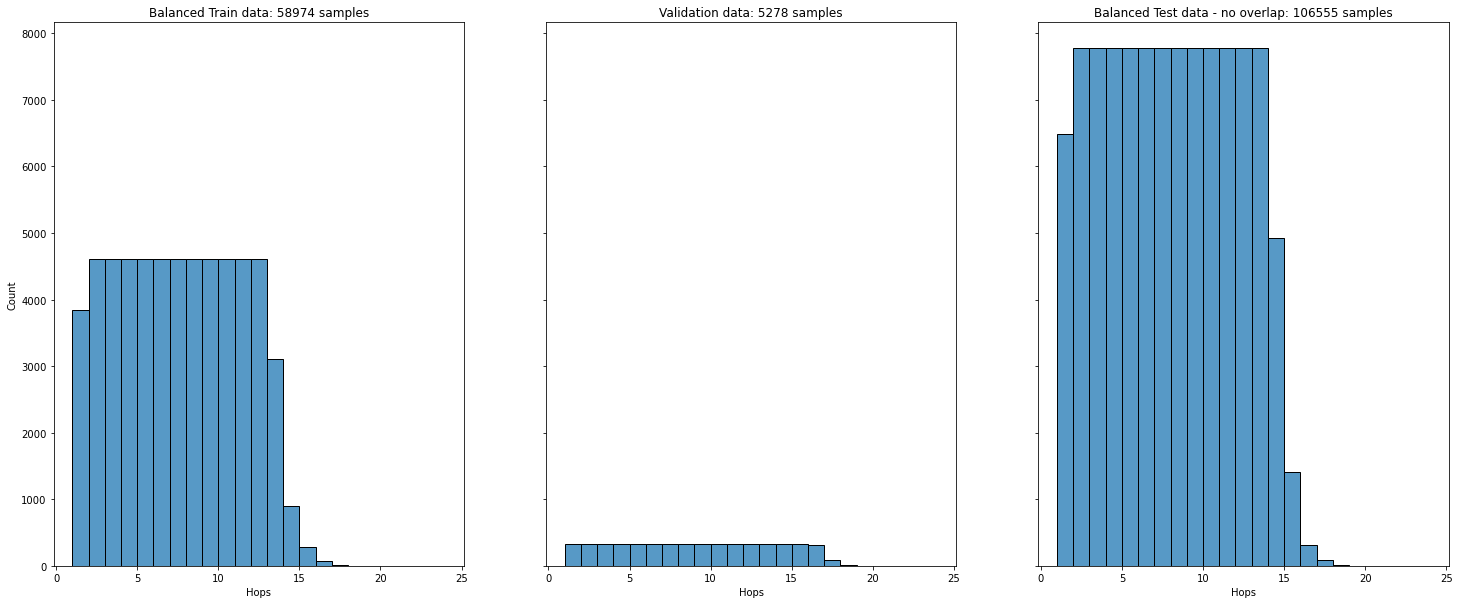

                                                      Head  \
1422524  SRC, SRC proto-oncogene, non-receptor tyrosine...   
1427623                      PRKCA, protein kinase C alpha   
36113                      3-Phospho-D-glyceroyl phosphate   
1563225                             CTNNB1, catenin beta 1   
1449680  HGS, hepatocyte growth factor-regulated tyrosi...   
...                                                    ...   
831191            ALG8, ALG8 alpha-1,3-glucosyltransferase   
853329                       Dolichyl D-glucosyl phosphate   
854291                       Dolichyl D-glucosyl phosphate   
832738       ALG10B, ALG10 alpha-1,2-glucosyltransferase B   
829643          MOGS, mannosyl-oligosaccharide glucosidase   

                                                      Tail      Hops  
1422524  RAF1, Raf-1 proto-oncogene, serine/threonine k...  1.000000  
1427623  TRPV4, transient receptor potential cation cha...  1.000000  
36113                           2,3-Bispho

In [18]:
y_transform = inverse_transform
x_train,y_train,x_valid,y_valid,x_sub_train,y_sub_train,x_test_balanced,y_test_balanced = Load_Datasets(
     'v8',y_transform = y_transform, Max_Hops_Samples_relativeToHop1 = 1.2, ValidationPercentageSplit = 0.05, SubTrainPercentage = 0.05)

In [204]:
class PubMedBERT(nn.Module):
    def __init__(self, checkpoint = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"):
        super().__init__()
        self.weight_path = checkpoint
        self.bert = AutoModel.from_pretrained(self.weight_path)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 1024), nn.ReLU(), nn.Dropout(0.2),
#             nn.Linear(2048, 2048), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(1024,512), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(512, 1)
            )

    def forward(self,input_ids, token_type_ids, attention_masks, return_dict=None):
        outputs = self.bert(input_ids, 
                            attention_mask=attention_masks,
                            token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        
        logits = self.linear_relu_stack(pooled_output)
        return logits
    
    
class tokenizer_input():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def save_pretrained(path):
        self.tokenizer.save_pretrained(path)
        
    def __call__(self, inputs_list):
        inputs = []
        for row in inputs_list:
            X_ls = row.split(' [SEP] ')
            inputs.append([X_ls[0],X_ls[1]])
        encoding = self.tokenizer(list(inputs), return_tensors='pt', padding=True)
        input_ids = encoding['input_ids'].to(self.device)
        token_type_ids = encoding['token_type_ids'].to(self.device)
        attention_masks = encoding['attention_mask'].to(self.device)
        return [input_ids, token_type_ids, attention_masks]


checkpoint = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
token_input = tokenizer_input(tokenizer)


def my_loss(output, target):
    loss = torch.mean(((output - target)**2)*(target+0.05/target)) # More attention to low hops
    return loss


criterion = my_loss

In [201]:
test_balanced_loader = DataLoader(tuple(zip(x_test_balanced,y_test_balanced)), batch_size=1, shuffle=True)
valid_loader = DataLoader(tuple(zip(x_valid,y_valid)), batch_size=1, shuffle=True)

# Load Best version for testing
model_PMB = torch.load("BestModelPubMeDFINAL.pth", map_location=torch.device('cpu'))
model_PMB.eval()


PubMedBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

  0%|          | 0/5278 [00:00<?, ?it/s]


Test Results:
		Loss: 0.018834
		Total Mean Squared Error: 0.0233
		Total Mean Absolute Error: 0.0827

 Hop '1'	MAE: 0.3389, MSE: 0.1814
 Hop '2'	MAE: 0.1841, MSE: 0.0486
 Hop '3'	MAE: 0.1260, MSE: 0.0268

Percentage of prediction > 0.5: 
 Hop  1: 	69.4444%
 Hops 2-3: 	25.6173%
 Hops 4-10: 	2.5573%
 Hops 11+: 	0.9814%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	74.2574%
Recall: 	69.4444%
Accuracy: 	96.1771%
f1: 		71.7703%
f1 Gain: 	96.7996%


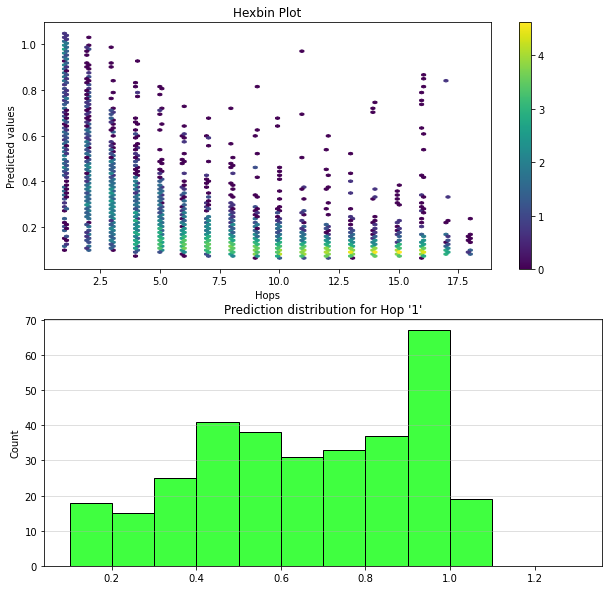

In [205]:
valid_preds, valid_labels = test_model(model_PMB, token_input, valid_loader, criterion)

In [206]:
y_true = np.array(valid_labels)
y_preds = np.array(valid_preds)
print(y_preds.shape)

del_index = []
for i in range(0,len(y_true)):
    if y_true[i] < 0.6 and y_true[i] >0.3:
        del_index.append(i)
        
y_true = np.delete(y_true, del_index)
y_true = np.floor(y_true)
y_preds = np.delete(y_preds, del_index)
print(y_scores.shape)

# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import PrecisionRecallDisplay
# prec, recall, thresholds = precision_recall_curve(y_true, y_preds, pos_label=1)
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

(5278,)
(4630,)


In [207]:
proportion = len(y_true[y_true == 1])/len(y_true[y_true != 1])
print('Positives to negatives proportion in validaion dataset: '+str(proportion))

recL = []
preL = []
f1L = []
recGL = []
preGL = []
f1GL = []
for t in thresholds:
    tp=tn=fp=fn =0
    for i in range(0,len(y_true)):

        if y_true[i] == 1:
            if y_preds[i] >t:
                tp += 1
            else:
                fn += 1
        elif y_true[i] < 0.3:
            if y_preds[i] >t:
                fp += 1
            else:
                tn += 1
    if tp > 0:
        pr = tp/(tp+fp)
        prG = (pr-proportion)/(pr*(1-proportion))
        re = tp/(tp+fn)
        reG = (re-proportion)/(re*(1-proportion))
        f1 = (2*pr*re)/(pr+re)
        f1G = (f1-proportion)/(f1*(1-proportion))
        preL.append(pr)
        recL.append(re)
        f1L.append(f1)
        preGL.append(prG)
        recGL.append(reG)
        f1GL.append(f1G)
    else:
        preL.append(0)
        recL.append(0)
        f1L.append(0)
        preGL.append(0)
        recGL.append(0)
        f1GL.append(0)

Positives to negatives proportion in validaion dataset: 0.07524384579656293


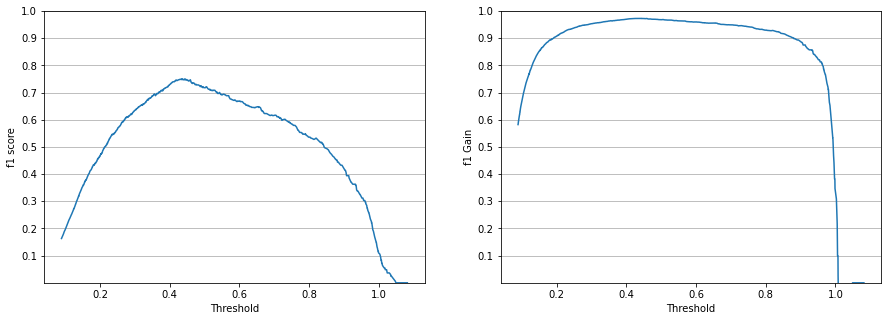

In [208]:
fig, axes = plt.fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].plot(thresholds, f1L)
axes[0].grid(axis = 'y')
axes[0].set_ylim([0, 1]) 
axes[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1])
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('f1 score')

axes[1].plot(thresholds, f1GL)
axes[1].grid(axis = 'y')
axes[1].set_ylim([0, 1]) 
axes[1].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1])
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('f1 Gain')

plt.show()

In [209]:
bestInd = np.argmax(f1L)
bestThreshold = thresholds[bestInd]
bestf1 = f1L[bestInd]
print("Best f1 = "+str(bestf1)+", with threshold = "+str(bestThreshold))

bestIndG = np.argmax(f1GL)
bestThresholdG = thresholds[bestIndG]
bestf1G = f1GL[bestIndG]
print("Best f1 Gain = "+str(bestf1G)+", with threshold = "+str(bestThresholdG))

Best f1 = 0.7503649635036496, with threshold = 0.44391822814941406
Best f1 Gain = 0.9729307174112299, with threshold = 0.44391822814941406


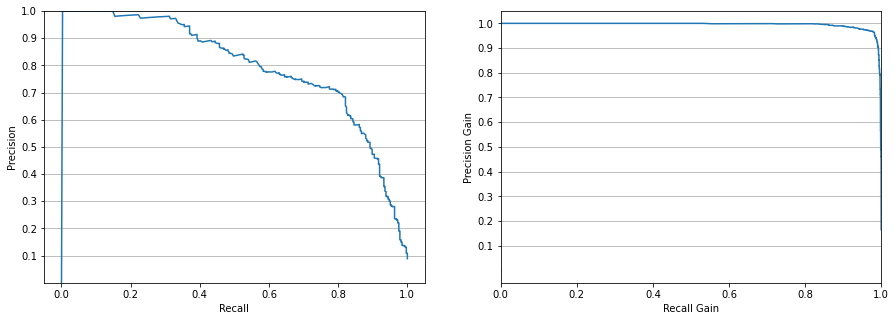

In [210]:
fig, axes = plt.fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].plot(recL,preL)
axes[0].grid(axis = 'y')
axes[0].set_ylim([0, 1]) 
axes[0].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1])
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')

axes[1].plot(recGL,preGL)
axes[1].grid(axis = 'y')
axes[1].set_xlim([0, 1]) 
axes[1].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1])
axes[1].set_xlabel('Recall Gain')
axes[1].set_ylabel('Precision Gain')

plt.show()

  0%|          | 0/106555 [00:00<?, ?it/s]


Test Results:
		Loss: 0.019261
		Total Mean Squared Error: 0.0246
		Total Mean Absolute Error: 0.0858

 Hop '1'	MAE: 0.3478, MSE: 0.1922
 Hop '2'	MAE: 0.1854, MSE: 0.0494
 Hop '3'	MAE: 0.1329, MSE: 0.0315

Percentage of prediction > 0.45: 
 Hop  1: 	73.5689%
 Hops 2-3: 	32.9369%
 Hops 4-10: 	3.4093%
 Hops 11+: 	0.8278%

Pseudo binary metrics (ignoring Hops 2 & 3): 
Precision: 	69.3729%
Recall: 	73.5689%
Accuracy: 	95.8044%
f1: 		71.4093%
f1 Gain: 	96.6749%


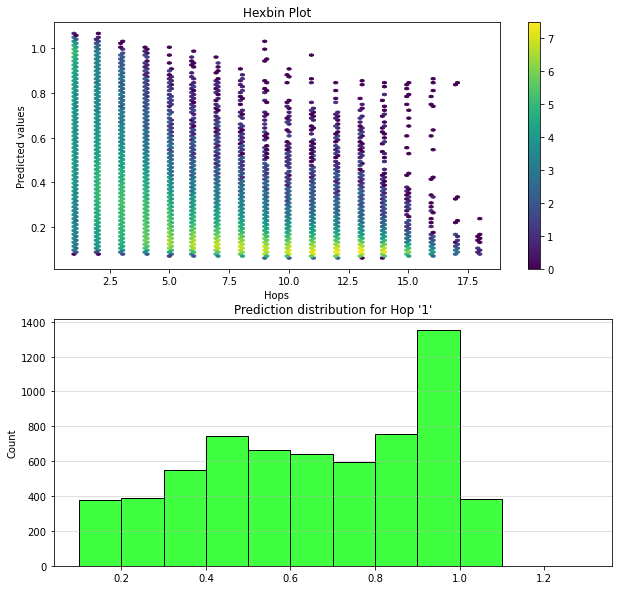

([0.7560685276985168,
  0.08528004586696625,
  0.08011860400438309,
  0.1080215573310852,
  0.2919990122318268,
  0.12670376896858215,
  0.07241258025169373,
  0.6962584257125854,
  0.1442517638206482,
  0.10435394942760468,
  0.267532616853714,
  0.45529213547706604,
  0.6972659826278687,
  0.0964030995965004,
  0.1885627955198288,
  0.2606521546840668,
  0.08939377218484879,
  0.09102434664964676,
  0.10813561081886292,
  0.07690217345952988,
  0.2670648396015167,
  0.20080481469631195,
  0.272568941116333,
  0.35598844289779663,
  0.09432192891836166,
  0.43886780738830566,
  0.2687436640262604,
  0.3313981890678406,
  0.54613196849823,
  0.123511902987957,
  0.24847403168678284,
  0.21982422471046448,
  0.34018728137016296,
  0.1161395013332367,
  0.5198708772659302,
  0.09853474050760269,
  0.11043472588062286,
  0.3288719654083252,
  0.09687457978725433,
  0.12882930040359497,
  0.17397327721118927,
  0.1657971441745758,
  0.14188355207443237,
  0.11311804503202438,
  0.140140965

In [212]:
test_model(model_PMB, token_input, test_balanced_loader, criterion)

In [167]:
def create_kegg_graph(data_df, include_reactions = True):
    
    G = nx.MultiDiGraph()  # At first create multigraph, later it can be converted
    
    unique_entries = []  # List of unique entries. Each gene, ompound, etc needs to be stored as 1 node
    
    # Iterate data to create all nodes
    for index, entry in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and entry['link type']=='reaction':
            continue            
        
        # -- Handle node for Head --
        n1 = entry['head id']
        if n1 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n1)
            
            #Add node n1
            G.add_node(n1)
            # Assign node type
            if n1[0:3] == 'hsa':
                t = 'gene'
            elif n1[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n1.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['head full name'] == '':
                full_name = n1
            else:
                full_name = entry['head full name']
            pathway = str(entry['pathway'])
            attr = {n1: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n1]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n1]['pathways'] = temp

        # -- Handle node for Tail --
        n2 = entry['tail id']
        if n2 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n2)
            
            #Add node n2
            G.add_node(n2)
            # Assign node type
            if n2[0:3] == 'hsa':
                t = 'gene'
            elif n2[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n2.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['tail full name'] == '':
                full_name = n2
            else:
                full_name = entry['tail full name']
            pathway = str(entry['pathway'])
            attr = {n2: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n2]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n2]['pathways'] = temp
        
        
     # Iterate data to find all relations           
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and row['link type']=='reaction':
            continue 
        
        head = str(row['head id'])
        tail = str(row['tail id'])
        pathway = str(row['pathway'])
        link_type = str(row['link type'])
        rel_name = str(row['relation name'])
        if head in G.nodes and tail in G.nodes:
            G.add_edge(head, tail,pathway = pathway, link_type= link_type, relation_name= rel_name)
        else:
            print('node not found @row '+str(index))
        
    return G

def merge_same_named(G):
    keep = []
    merge = []
    merged_list = []
    for node1 in tqdm(G.nodes):
        for node2 in G.nodes:
            if node1 != node2:
                if G.nodes[node1]['full name'] == G.nodes[node2]['full name']:
                    merged_list.append("Merge: "+node1+" + "+node2+ " as "+G.nodes[node1]['full name'])
                    # Prefer to merge glycan as compound
                    if node1[0:3] == 'cpd':
                        keep.append(node1)
                        merge.append(node2)
                    else:
                        keep.append(node2)
                        merge.append(node1)
                        
    for n1,n2 in zip(keep,merge):
        if n1 in G.nodes and n2 in G.nodes:
            G = nx.contracted_nodes(G,n1,n2)
            
    
    return G, merged_list    

In [169]:
# === load data ===
import networkx as nx
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names.csv')
G_directed = create_kegg_graph(df_relations)
G_undirected = nx.Graph(G_directed)
print(G_undirected)
# Merge some double occurrences of compounds as glycans
G_undirected,ml = merge_same_named(G_undirected)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17448/17448 [00:01<00:00, 12385.14it/s]


Graph with 5187 nodes and 11804 edges


100%|█████████████████████████████████████████████████████████████████████████████| 5187/5187 [00:47<00:00, 108.26it/s]


Graph with 5165 nodes and 11791 edges


In [170]:
# Keep main component only. Prevent biased zeros to unconnected nodes
largest_cc = max(nx.connected_components(G_undirected), key=len)
lsmain = list(largest_cc)

G_undirected_main = G_undirected.copy()
remove = []
for node in G_undirected_main.nodes:
    if node not in lsmain:
        remove.append(node)
        
for node in remove:        
    G_undirected_main.remove_node(node)
        
print(G_undirected_main)

Graph with 4810 nodes and 11577 edges


In [177]:
# Load nodes and test set
save_version = 'v8'

df_nodes_A = pd.read_csv('../KEGG Undirected Graph Dataset/Hops Dataset '+save_version+' - Nodes A.csv')
lsA = list(df_nodes_A['0'])

df_nodes_B = pd.read_csv('../KEGG Undirected Graph Dataset/Hops Dataset '+save_version+' - Nodes B.csv')
lsB = list(df_nodes_B['0'])

test_set = pd.read_csv('../KEGG Undirected Graph Dataset/Hops Dataset '+save_version+' - B.csv')

color_map = []
for node in G_undirected_main:
    if node in lsA:
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [189]:
# Find a pair to test
target_length = 2

target_len_set = test_set[test_set['Hops'] == target_length]
            
# print(target_len_set)

test_source_name = target_len_set.iloc[0]['Head']
test_target_name = target_len_set.iloc[0]['Tail']

for node in G_undirected_main.nodes:
    if  G_undirected_main.nodes[node]["full name"] == test_source_name:
        test_source = node
        break

for node in G_undirected_main.nodes:
    if  G_undirected_main.nodes[node]["full name"] == test_target_name:
        test_target = node
        break
    
        

print("Testing for source node: "+test_source+" (" + test_source_name+")\nand target node: "+test_target+"(" + test_target_name+")")

path = nx.shortest_path(G_undirected_main, source=test_source, target=test_target)
print("\nCorrect path:")
print(path)

Testing for source node: hsa:441531 (PGAM4, phosphoglycerate mutase family member 4)
and target node: hsa:160287(LDHAL6A, lactate dehydrogenase A like 6A)

Correct path:
['hsa:441531', 'hsa:4609', 'hsa:160287']


In [196]:
all_nodes = list(G_undirected_main.nodes)


current_node = test_source
best_next_node = 'placeholder'
best_next_value = 0
predicted_path = []
found = False

for steps in range(1,10):
    if not found:
        current_name = G_undirected_main.nodes[current_node]['full name']
        status = tqdm(all_nodes)
        for node in status:
            name = G_undirected_main.nodes[node]['full name']
            input_tensors = token_input(name+' [SEP] '+current_name)     
            outputs = model_PMB(*input_tensors)
            val = outputs[0].cpu().detach().item()
            if val > best_next_value:
                status.set_description("Best next value: "+str(best_next_value))
                best_next_value = val
                best_next_node = node
                if best_next_node == test_target:
                    print("Found!")
                    predicted_path.append(best_next_node)
                    found = True
                    
        predicted_path.append(best_next_node)
        current_node = best_next_node
        




Best next value: 0.387100487947464:  25%|██████████▍                               | 1201/4810 [13:33<40:45,  1.48it/s]


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [197]:
tokenizer("HuggingFace is based in NYC [SEP] Where is HuggingFace based?")

{'input_ids': [2, 5897, 3312, 1941, 6016, 1972, 1977, 2454, 1922, 8932, 1030, 3, 2597, 1977, 5897, 3312, 1941, 6016, 1972, 2454, 35, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [198]:
x_test_balanced[1]

'Tyramine [SEP] DDC, dopa decarboxylase'

In [199]:
tokenizer(x_test_balanced[1])

{'input_ids': [2, 9036, 3812, 3, 6758, 1030, 16, 19428, 23922, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}